In [ ]:
!pip install pyro-ppl -qq

     |████████████████████████████████| 713 kB 5.0 MB/s 


In [ ]:
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import exists, join, basename
from os import makedirs, remove
from tqdm.notebook import tqdm

import urllib
import tarfile
import imageio
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSD300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir

download_bsd300('/content/dataset')

downloading url  http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz


'/content/dataset/BSD300/images'

In [ ]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule

In [ ]:
upscale = 2
center_crop = 300
input_transform = Compose(
    [ToTensor(),
    CenterCrop(center_crop),
    Resize(center_crop // upscale)])
target_transform = Compose(
    [ToTensor(),
     CenterCrop(center_crop),
    Resize(center_crop)])


from PIL import Image

class SRDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, transform=None):
        self.path_to_images = path_to_images
        self.transform = transform

    def __len__(self):
      return len(os.listdir(self.path_to_images))

    def __getitem__(self, i):
        self.imagepath = join(
            self.path_to_images,
            os.listdir(self.path_to_images)[i],
        )
        img = Image.open(self.imagepath).convert('YCbCr')
        y, _, _ = img.split()

        input = input_transform(y.copy())
        target = target_transform(y.copy())
        return {'input':input, 'target':target}
      
train_set = SRDataset('/content/dataset/BSDS300/images/train')
test_set = SRDataset('/content/dataset/BSDS300/images/test')

In [ ]:
class CNN(nn.Module):
    def __init__(self, upscale):
        self.upscale = upscale

        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, self.upscale**2, kernel_size=3, stride=1, padding=1)
        self.psh = nn.PixelShuffle(self.upscale)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.psh(x)

        return x

test = CNN(3)
print(test(torch.rand(1, 1, 100, 100)).shape)

torch.Size([1, 1, 300, 300])


In [ ]:
from pyro.nn.module import to_pyro_module_
model = CNN(3)
to_pyro_module_(model)


In [ ]:
# def pyro_forward(self, x, y=None):
#     logits = self._forward(x)
#     probs = nn.functional.softmax()

In [ ]:
from pyro.nn import PyroSample

def add_priors(model):
  for m in model.modules():
    for name, value in list(m.named_parameters(recurse=False)):
      mean = torch.tensor(0.).to(device)
      sigma = torch.tensor(1.).to(device)
      setattr(m, name, PyroSample(dist.Normal(mean, sigma).expand(value.shape).to_event(value.dim())))

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

In [ ]:
def train(svi, train_loader):

    epoch_loss = 0.
    for batch in train_loader:
        input, target = batch['input'].to(device), batch['target'].to(device)

        epoch_loss += svi.step(input, target)

    loss_train = epoch_loss / len(train_loader.dataset)

    return loss_train

In [ ]:
def pyro_forward(self, x, y=None):
    result = self._forward(x)

    return result

In [ ]:
pyro.clear_param_store()

model = CNN(3)
to_pyro_module_(model)
add_priors(model)
guide = AutoDiagonalNormal(model)

model._forward = model.forward.__get__(model, CNN)
model.forward = pyro_forward.__get__(model, CNN)

In [ ]:
from pyro.infer import SVI, Trace_ELBO

model.to(device)
guide.to(device)

adam_parameters = {'lr':0.01}
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({
    'optimizer':optimizer,
    'optim_args':adam_parameters,
    'gamma':0.99})

svi = SVI(model, guide, scheduler, loss=Trace_ELBO())

In [ ]:
from PIL import Image

class SRDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, transform=None):
        self.path_to_images = path_to_images
        self.transform = transform

    def __len__(self):
      return len(os.listdir(self.path_to_images))

    def __getitem__(self, i):
        self.imagepath = join(
            self.path_to_images,
            os.listdir(self.path_to_images)[i],
        )
        img = Image.open(self.imagepath).convert('YCbCr')
        y, _, _ = img.split()

        input = input_transform(y.copy())
        target = target_transform(y.copy())
        return {'input':input, 'target':target}
      
train_set = SRDataset('/content/dataset/BSDS300/images/train')
test_set = SRDataset('/content/dataset/BSDS300/images/test')
training_loader = torch.utils.data.DataLoader(dataset=train_set, num_workers=2, batch_size=50, shuffle=True)
testing_loader =  torch.utils.data.DataLoader(dataset=test_set, num_workers=2, batch_size=1, shuffle=False)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
train_elbo = []
num_epoch = 500

for epoch in tqdm(range(num_epoch)):
    elbo = train(svi, training_loader)
    train_elbo.append(-elbo)
    scheduler.step()

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
path = '/content/dataset/BSDS300/images/test/85048.jpg'
img = Image.open(path).convert('YCbCr')
y, cb, cr = img.split()

# input = input_transform(y)
# input = input.view(1, -1, y.size[1], y.size[0])
input = input_transform(y).unsqueeze(0)
model = model.eval().to(device)
input = input.to(device)

out = model.forward(input)
out = out.cpu().squeeze(0)

(450, 450)


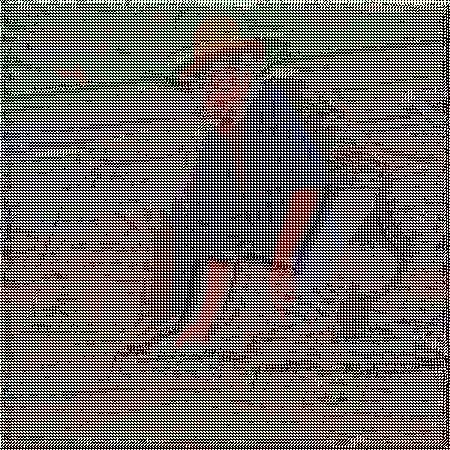

In [ ]:
out_img_y = out[0].data.numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
print(out_img_y.shape)
out_img_y = Image.fromarray(np.uint8(out_img_y), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
out_img

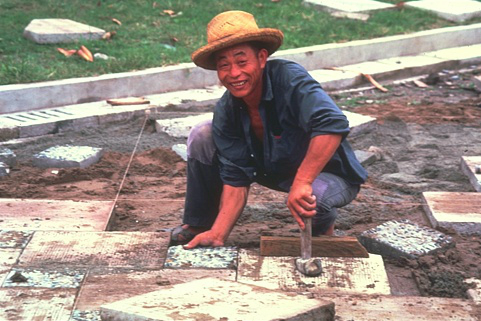

In [ ]:
img.convert('RGB')